# Model_X

# 1. Setup and Data Loading

In [3]:
# --- 1. Install Necessary Libraries ---
# (Run these lines once if you don't have them in your new environment)
#!pip install xgboost catboost shap

# --- 2. Import All Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# --- 3. Load Data ---
# IMPORTANT: Update this path to where your CSV file is located
DATA_FILE_PATH = './Dataset/Dementia Prediction Dataset.csv' 
TARGET_COLUMN = 'DEMENTED'

try:
    data = pd.read_csv(DATA_FILE_PATH)
    print(f"Successfully loaded data. Shape: {data.shape}")
    print(f"Target column '{TARGET_COLUMN}' found.")
except (FileNotFoundError, KeyError):
    print(f"Error: Could not load data or find target column.")
    print("Please check DATA_FILE_PATH and TARGET_COLUMN variables.")
    # Create a small dummy dataset for demonstration if file isn't found
    data = pd.DataFrame({
        'NACCAGE': [65, 70, 80, 75, 999], 'SEX': [1, 2, 1, 2, 1], 'EDUC': [12, 16, 8, 20, 99],
        'MARISTAT': [1, 2, 1, 5, 9], 'RACE': [1, 1, 2, 5, 99], 'INRELTO': [1, 2, 9, 3, 1],
        'CVHATT': [0, 1, 2, 0, 9], 'CBSTROKE': [0, 0, 1, 0, 9], 'DIABETES': [0, 2, 1, 0, 9],
        'HYPERTEN': [1, 1, 0, 0, 9], 'HYPERCHO': [1, 0, 2, 9, 0], 'TBI': [0, 0, 0, 0, 9], 
        'DEP2YRS': [0, 1, 0, 0, 9], 'NACCBMI': [25.1, 28.9, 32.0, 22.4, 888.8],
        'DEMENTED': [0, 1, 1, 0, 1]
    })
    print(f"Loaded dummy data for demonstration. Shape: {data.shape}")

/var/folders/f8/s7_j6j8j5y5dccj4rpr3xjgw0000gn/T/ipykernel_9880/2337633395.py:32: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_FILE_PATH)


Successfully loaded data. Shape: (195196, 1024)
Target column 'DEMENTED' found.


# 2. Preprocessing and Feature Engineering

In [5]:
# --- 1. Define Feature Sets ---
# Based on hackathon rules: A1, A2, A5, B1 are allowed.

# Numerical features that will be imputed (median) and scaled
numeric_features = [
    'NACCAGE',  # Subject's age [cite: 26]
    'EDUC',     # Subject's years of education [cite: 24]
    'NACCBMI'   # Subject's Body Mass Index [cite: 38]
]

# Categorical features that will be imputed (most frequent) and one-hot encoded
categorical_features = [
    'SEX',      # Subject's sex [cite: 24]
    'MARISTAT', # Marital status [cite: 26]
    'RACE',     # Subject's race [cite: 24]
    'INRELTO'   # Co-participant's relationship to subject [cite: 27]
]

# Self-reported health history (Form A5)
# We will binarize these and engineer a new feature
health_history_features = [
    'CVHATT',   # Heart attack [cite: 32]
    'CBSTROKE', # Stroke [cite: 32]
    'DIABETES', # Diabetes [cite: 34]
    'HYPERTEN', # Hypertension [cite: 34]
    'HYPERCHO', # Hypercholesterolemia [cite: 34]
    'TBI',      # Traumatic Brain Injury [cite: 34]
    'DEP2YRS'   # Depression in last 2 years [cite: 36]
]

# --- 2. Clean Missing/Unknown Values ---
# We replace all non-standard "missing" or "unknown" codes with np.nan
# This is critical for scikit-learn's imputers to work.
missing_values_map = {
    'NACCAGE': [999],           # [cite: 420]
    'EDUC': [99],               # [cite: 367]
    'NACCBMI': [888.8, 888],    # [cite: 1118]
    'MARISTAT': [9],            # [cite: 377]
    'RACE': [99],               # [cite: 295]
    'INRELTO': [9],             # [cite: 588]
    # For Form A5, 9 means "Unknown"
    'CVHATT': [9], 'CBSTROKE': [9], 'DIABETES': [9], 'HYPERTEN': [9], # [cite: 1094, 1098, 1105, 1106]
    'HYPERCHO': [9], 'TBI': [9], 'DEP2YRS': [9] # [cite: 1107, 1102, 1115]
}

for col, missing_vals in missing_values_map.items():
    if col in data.columns:
        data[col] = data[col].replace(missing_vals, np.nan)

print("Replaced special 'missing' codes with NaN.")

# --- 3. Feature Engineering ---
# 3a. Binarize Health History
# We map 0=Absent to 0, and 1=Recent/Active or 2=Remote/Inactive to 1 (Present).
for col in health_history_features:
    if col in data.columns:
        data[col] = data[col].map({0: 0, 1: 1, 2: 1})

# 3b. Create 'ComorbidityCount'
# This counts how many conditions are present.
# We fill NaNs with 0 (assuming 'unknown' means 'absent') before summing.
data['ComorbidityCount'] = data[health_history_features].fillna(0).sum(axis=1)

# Add our new engineered feature to the numeric list
numeric_features.append('ComorbidityCount')
print("Engineered 'ComorbidityCount' feature.")

# --- 4. Separate Features (X) and Target (y) ---
if TARGET_COLUMN not in data.columns:
    print(f"FATAL ERROR: Target column '{TARGET_COLUMN}' not found!")
else:
    X = data[numeric_features + categorical_features]
    y = data[TARGET_COLUMN]

    # --- 5. Define Preprocessing Pipelines ---
    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # --- 6. Create the ColumnTransformer ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop' # Drop any columns we didn't explicitly select
    )

    # --- 7. Apply Preprocessing ---
    X_processed = preprocessor.fit_transform(X)

    # Get the new feature names (e.g., after one-hot encoding)
    feature_names = preprocessor.get_feature_names_out()
    
    # Convert the processed data back to a DataFrame for easier inspection
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

    print("\n--- Preprocessing Complete ---")
    print(f"Shape of processed features (X): {X_processed.shape}")
    print(f"Shape of target (y): {y.shape}")
    print("\nProcessed features (first 5 rows):")
    print(X_processed_df.head())

Replaced special 'missing' codes with NaN.
Engineered 'ComorbidityCount' feature.

--- Preprocessing Complete ---
Shape of processed features (X): (195196, 26)
Shape of target (y): (195196,)

Processed features (first 5 rows):
   num__NACCAGE  num__EDUC  num__NACCBMI  num__ComorbidityCount  cat__SEX_1.0  \
0     -0.424061   0.136566      0.831051               1.549393           1.0   
1     -0.327002   0.136566      0.683279              -0.858180           1.0   
2     -0.812297   0.136566      0.074805              -0.858180           1.0   
3     -1.103474   0.136566      0.222577              -0.858180           0.0   
4      0.255351  -1.107783     -0.333743              -0.858180           1.0   

   cat__SEX_2.0  cat__MARISTAT_1.0  cat__MARISTAT_2.0  cat__MARISTAT_3.0  \
0           0.0                1.0                0.0                0.0   
1           0.0                1.0                0.0                0.0   
2           0.0                1.0                0.0     

# 3. Exploratory Data Analysis: Correlation Heatmap

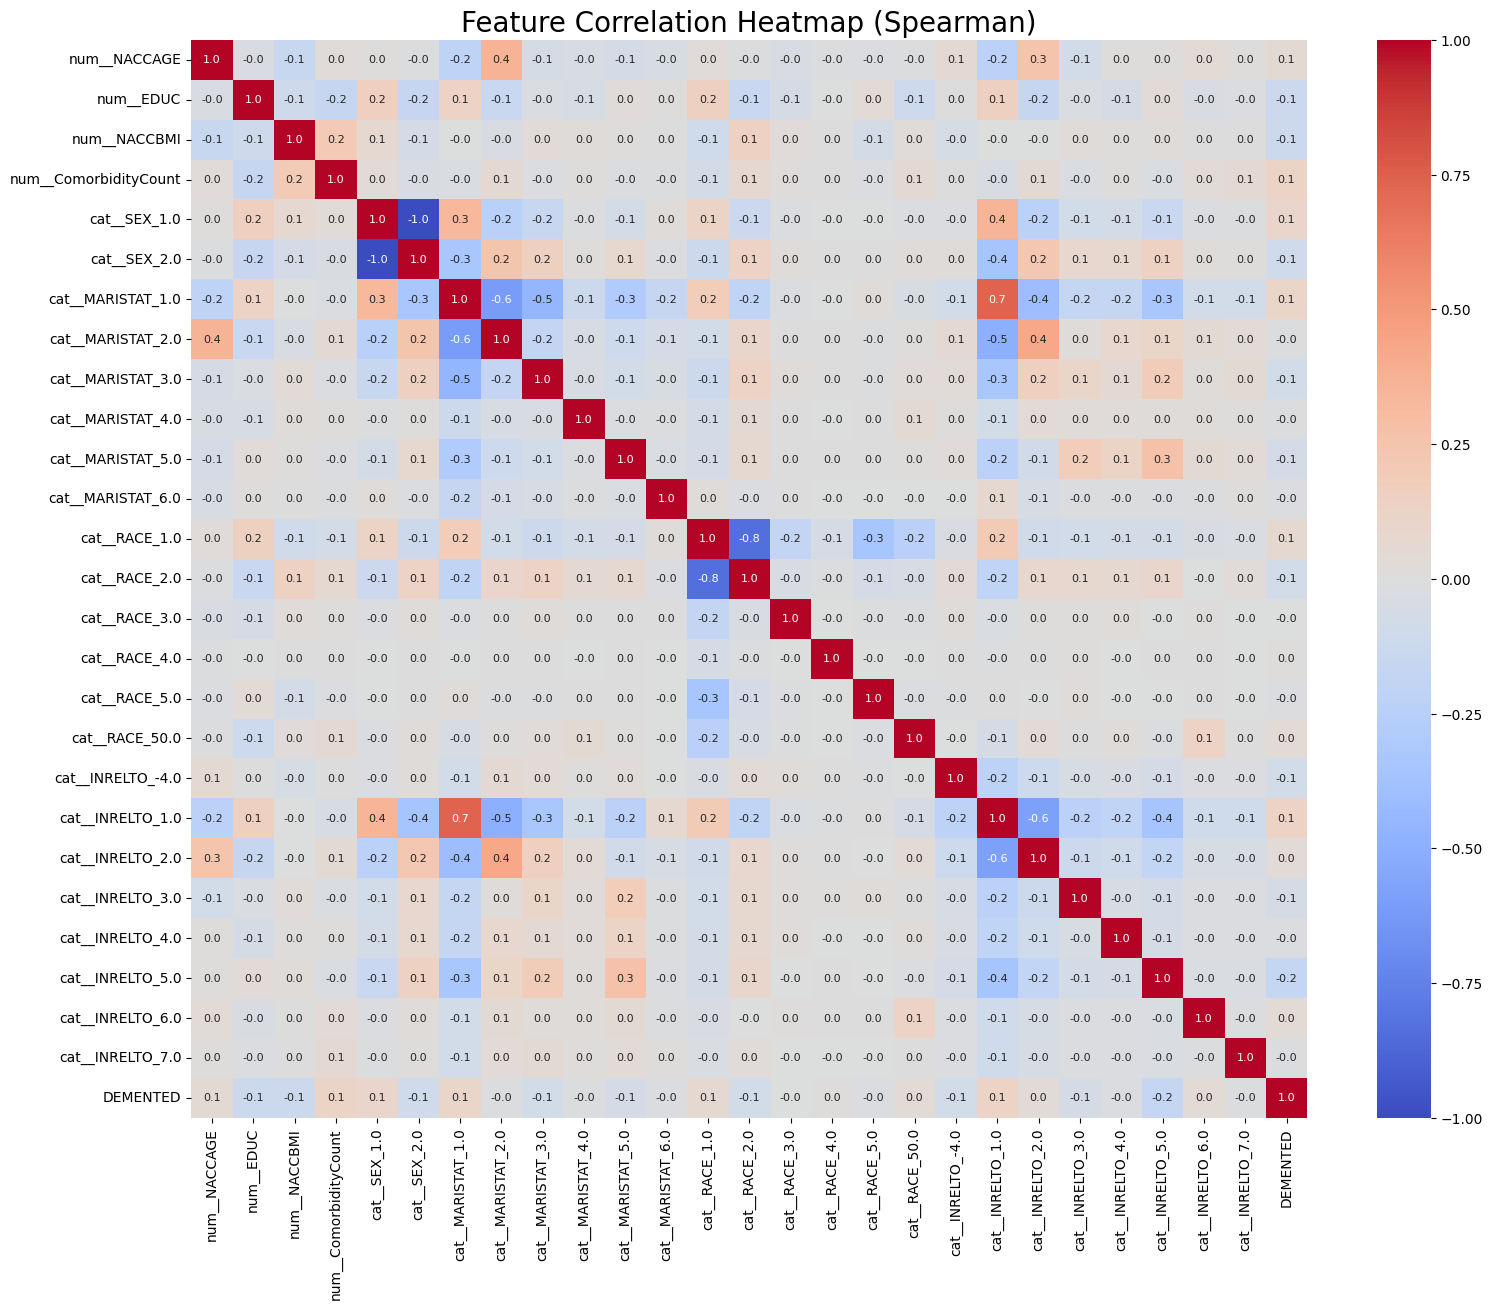


Top correlations with 'DEMENTED':
cat__INRELTO_5.0        -0.166740
num__EDUC               -0.127410
cat__INRELTO_1.0         0.127074
num__NACCBMI            -0.120441
num__ComorbidityCount    0.118911
cat__MARISTAT_1.0        0.104663
cat__SEX_1.0             0.097707
cat__SEX_2.0            -0.097707
cat__MARISTAT_3.0       -0.084486
cat__INRELTO_-4.0       -0.083915
Name: DEMENTED, dtype: float64


In [6]:
# --- 1. Create a DataFrame for Correlation ---
# We use your 'X_processed_df' (from the previous cell)
# and add the 'y' target variable back so we can see
# how each feature correlates with the 'DEMENTED' target.

# Make sure 'y' is a Series with the same index as X_processed_df
y_reset = y.reset_index(drop=True)

# Combine processed features and the target
corr_df = X_processed_df.join(y_reset.to_frame(TARGET_COLUMN))

# --- 2. Calculate the Correlation Matrix ---
# We'll use the 'spearman' method, which is good for non-linear relationships
corr_matrix = corr_df.corr(method='spearman')

# --- 3. Plot the Heatmap ---
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr_matrix, 
    annot=True,          # Show the correlation numbers
    cmap='coolwarm',     # Use a blue-to-red color map
    fmt='.1f',           # Format numbers to one decimal place
    annot_kws={"size": 8}
)
plt.title('Feature Correlation Heatmap (Spearman)', fontsize=20)
plt.savefig('correlation_heatmap.png')  # Saves the plot for your report
plt.show()

# --- 4. Get Top Correlations with the Target ---
print(f"\nTop correlations with '{TARGET_COLUMN}':")
# Sort by the absolute value to see the strongest relationships, positive or negative
target_corr = corr_matrix[TARGET_COLUMN].drop(TARGET_COLUMN).sort_values(ascending=False, key=abs)
print(target_corr.head(10))

# 4. Split Data for Training and Testing

In [7]:
# --- 1. Split Data ---
# We use X_processed (the NumPy array) for faster training
# We use y (the original target Series)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, 
    y, 
    test_size=0.2,    # Use 20% of the data for testing
    random_state=42,  # Ensures your split is reproducible
    stratify=y        # Ensures the train and test sets have the same
                      # proportion of dementia cases, which is vital
                      # for an imbalanced dataset.
)

print("--- Data Splitting Complete ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")

--- Data Splitting Complete ---
X_train shape: (156156, 26)
X_test shape:  (39040, 26)
y_train shape: (156156,)
y_test shape:  (39040,)


# 5. Model Development and Comparison

In [8]:
# --- 1. Train Baseline Model: Logistic Regression ---
print("--- Training Logistic Regression ---")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_preds)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(classification_report(y_test, lr_preds))
print("-" * 40)

# --- 2. Train Random Forest Classifier ---
print("--- Training Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_preds))
print("-" * 40)

# --- 3. Train XGBoost Classifier ---
print("--- Training XGBoost Classifier ---")
xgb_model = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)

print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(classification_report(y_test, xgb_preds))
print("-" * 40)

# --- 4. Train CatBoost Classifier ---
print("--- Training CatBoost Classifier ---")
cat_model = CatBoostClassifier(
    random_seed=42,
    verbose=0  # Suppress training output
)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_preds)

print(f"CatBoost Accuracy: {cat_accuracy:.4f}")
print(classification_report(y_test, cat_preds))
print("-" * 40)

# --- 5. Final Model Comparison ---
print("\n--- 🏆 Model Performance Summary ---")
print(f"Logistic Regression: {lr_accuracy:.4f}")
print(f"Random Forest:       {rf_accuracy:.4f}")
print(f"XGBoost:             {xgb_accuracy:.4f}")
print(f"CatBoost:            {cat_accuracy:.4f}")

--- Training Logistic Regression ---
Logistic Regression Accuracy: 0.7179
              precision    recall  f1-score   support

           0       0.74      0.93      0.82     27522
           1       0.56      0.20      0.30     11518

    accuracy                           0.72     39040
   macro avg       0.65      0.57      0.56     39040
weighted avg       0.68      0.72      0.67     39040

----------------------------------------
--- Training Random Forest ---
Random Forest Accuracy: 0.7225
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     27522
           1       0.54      0.42      0.47     11518

    accuracy                           0.72     39040
   macro avg       0.66      0.64      0.64     39040
weighted avg       0.71      0.72      0.71     39040

----------------------------------------
--- Training XGBoost Classifier ---


/opt/anaconda3/envs/metal/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7394
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     27522
           1       0.62      0.31      0.41     11518

    accuracy                           0.74     39040
   macro avg       0.69      0.61      0.62     39040
weighted avg       0.72      0.74      0.71     39040

----------------------------------------
--- Training CatBoost Classifier ---
CatBoost Accuracy: 0.7411
              precision    recall  f1-score   support

           0       0.76      0.92      0.83     27522
           1       0.63      0.30      0.41     11518

    accuracy                           0.74     39040
   macro avg       0.69      0.61      0.62     39040
weighted avg       0.72      0.74      0.71     39040

----------------------------------------

--- 🏆 Model Performance Summary ---
Logistic Regression: 0.7179
Random Forest:       0.7225
XGBoost:             0.7394
CatBoost:            0.7411


the winning model was CatBoost.
therefore, continued to use it

# 6. Hyperparameter Tuning

In [11]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# (This assumes 'X_train', 'X_test', 'y_train', 'y_test', 
# and 'cat_accuracy' are still in memory)

print("--- Starting CatBoost Native Hyperparameter Tuning ---")

# 1. Create a "Pool" - CatBoost's native data format
# This is more efficient for CatBoost's internal functions
train_pool = Pool(X_train, y_train)

# 2. Define the grid of parameters to try
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]  # L2 Regularization
}

# 3. Initialize the base model
# Note: We create a new model instance for tuning
cat_model_to_tune = CatBoostClassifier(
    random_seed=42,
    verbose=0,
    eval_metric='Accuracy'  # We want to optimize for accuracy
)

# 4. Run the built-in randomized_search
# This is much faster than the scikit-learn version
randomized_search_result = cat_model_to_tune.randomized_search(
    param_grid,
    X=train_pool,
    n_iter=10,       # Try 10 random combinations
    cv=3,            # 3-fold cross-validation
    verbose=False,   # Set to True if you want to see progress per fold
    plot=True        # This will show a live-updating plot
)

print("\n--- Tuning Complete ---")

--- Starting CatBoost Native Hyperparameter Tuning ---


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7357838115
bestIteration = 992


bestTest = 0.7414510758
bestIteration = 1476


bestTest = 0.743564293
bestIteration = 499


bestTest = 0.7392418033
bestIteration = 997


bestTest = 0.7451331967
bestIteration = 1268


bestTest = 0.7449731045
bestIteration = 375


bestTest = 0.743564293
bestIteration = 433


bestTest = 0.745517418
bestIteration = 999


bestTest = 0.7456454918
bestIteration = 724


bestTest = 0.7414510758
bestIteration = 1495

Training on fold [0/3]

bestTest = 0.7426661288
bestIteration = 676

Training on fold [1/3]

bestTest = 0.7412395297
bestIteration = 999

Training on fold [2/3]

bestTest = 0.7416956447
bestIteration = 989


--- Tuning Complete ---


In [12]:
print('-' * 20 + ' results ' + '-' * 20)

print("Best Parameters found:")
print(randomized_search_result['params'])

# 5. Get the new, tuned model (it's automatically updated)
best_cat_model = cat_model_to_tune

# 6. Evaluate the NEW, tuned model
tuned_preds = best_cat_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, tuned_preds)

print(f"\nOriginal CatBoost Accuracy: {cat_accuracy:.4f}")
print(f"Tuned CatBoost Accuracy:  {tuned_accuracy:.4f}")

print("\nTuned CatBoost Classification Report:")
print(classification_report(y_test, tuned_preds))

print(f'\nImprovement in Accuracy: {tuned_accuracy - cat_accuracy:.4f}')
print("\n--- Hyperparameter Tuning Finished ---")

-------------------- results --------------------
Best Parameters found:
{'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 1000}

Original CatBoost Accuracy: 0.7411
Tuned CatBoost Accuracy:  0.7428

Tuned CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.84     27522
           1       0.63      0.31      0.41     11518

    accuracy                           0.74     39040
   macro avg       0.70      0.62      0.62     39040
weighted avg       0.72      0.74      0.71     39040


Improvement in Accuracy: 0.0016

--- Hyperparameter Tuning Finished ---


# 7. Explainability : Feature Importance & SHAP

--- Generating Feature Importance from Tuned Model ---


/var/folders/f8/s7_j6j8j5y5dccj4rpr3xjgw0000gn/T/ipykernel_9880/2721442853.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


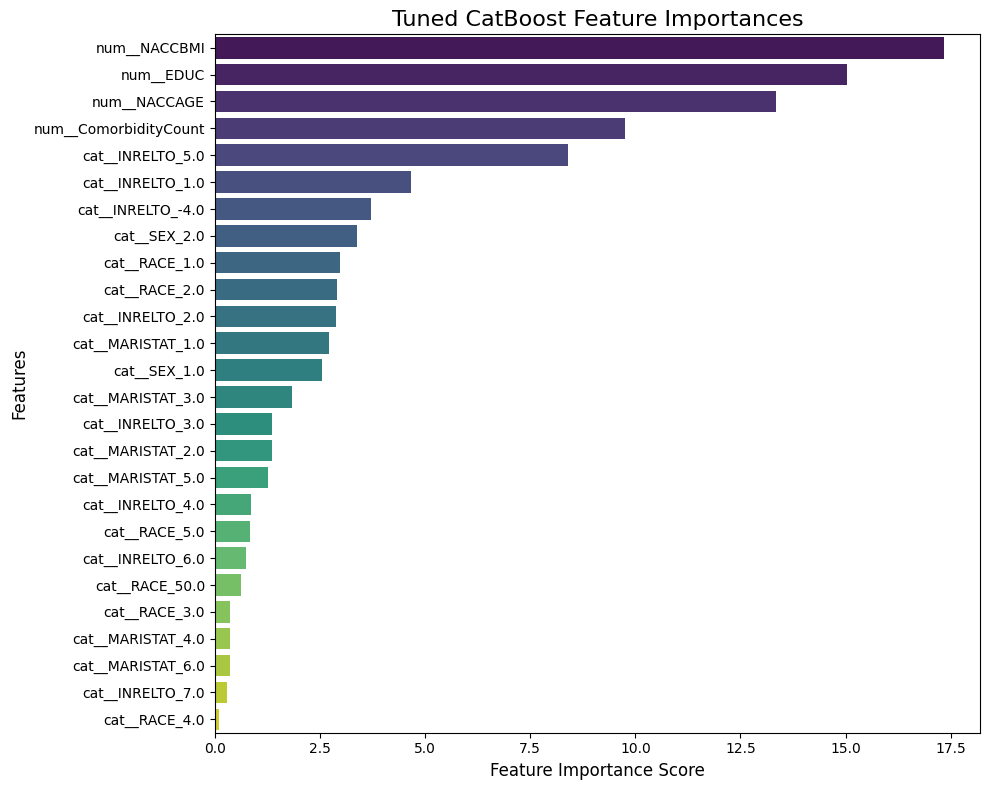

num__NACCBMI             17.329703
num__EDUC                15.037433
num__NACCAGE             13.340221
num__ComorbidityCount     9.748772
cat__INRELTO_5.0          8.401907
cat__INRELTO_1.0          4.667341
cat__INRELTO_-4.0         3.706052
cat__SEX_2.0              3.386483
cat__RACE_1.0             2.988019
cat__RACE_2.0             2.896631
dtype: float64
----------------------------------------

--- Calculating SHAP values (this may take a moment) ---
--- Generating SHAP Summary Plot ---
SHAP plot saved as 'shap_summary_plot.png'


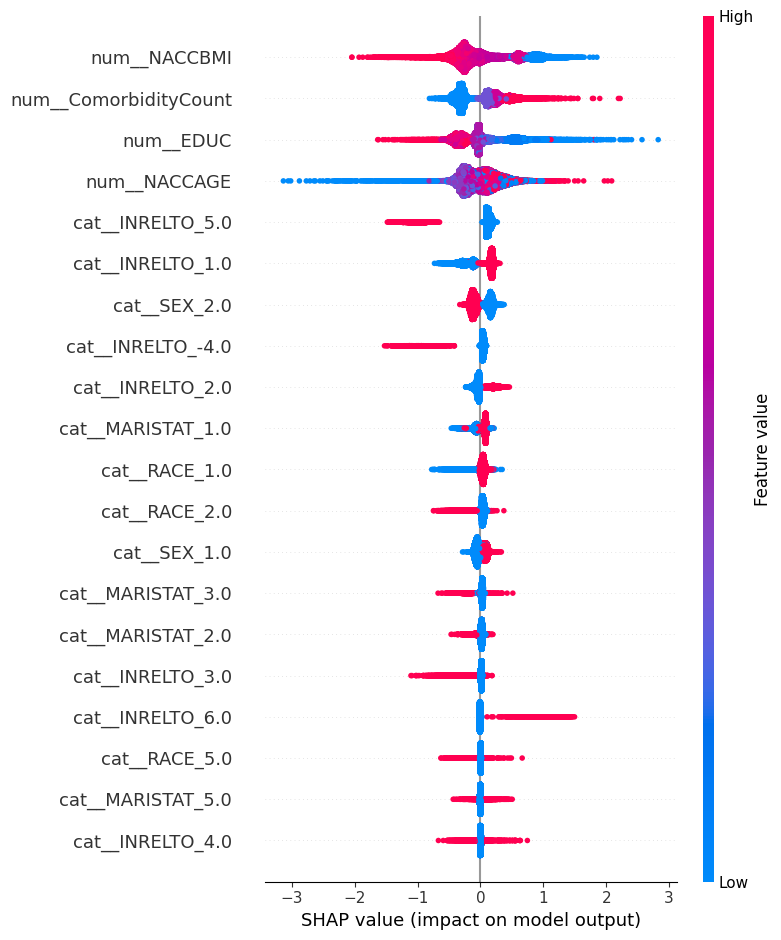

In [13]:
# --- 1. Get Standard Feature Importance ---
# This uses the 'best_cat_model' from your tuning step

print("--- Generating Feature Importance from Tuned Model ---")

# Get importances from the tuned model
tuned_importances = best_cat_model.get_feature_importance()

# (This requires the 'feature_names' variable from cell #2)
tuned_feature_importance_df = pd.Series(
    tuned_importances, 
    index=feature_names
).sort_values(ascending=False)

# --- Plot the Feature Importance ---
plt.figure(figsize=(10, 8))
sns.barplot(
    x=tuned_feature_importance_df.values, 
    y=tuned_feature_importance_df.index, 
    palette='viridis'
)
plt.title('Tuned CatBoost Feature Importances', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig('catboost_tuned_feature_importance.png') # Save for your report
plt.show()

print(tuned_feature_importance_df.head(10))
print("-" * 40)


# --- 2. Generate SHAP Explanations ---
# This provides deeper insight into *how* features impact the model

print("\n--- Calculating SHAP values (this may take a moment) ---")

# SHAP works best on a sample of the data. Let's use the test set.
# We need to wrap our model and data for the SHAP library
explainer = shap.TreeExplainer(best_cat_model)
shap_values = explainer.shap_values(X_test)

print("--- Generating SHAP Summary Plot ---")

# This plot shows the most important features (top) and how
# high values (red) or low values (blue) of that feature
# impact the prediction (left = lower risk, right = higher risk).
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=feature_names, 
    show=False
)

# Save the plot for your report
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
print("SHAP plot saved as 'shap_summary_plot.png'")